In [30]:
!pip install xgboost
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import AdaBoostRegressor

In [42]:
air = pd.read_csv('data/AirPass.csv')
air = air.drop(columns='Unnamed: 0')
air.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


Задание 6.1

Для начала сделаем небольшую предобработку данных. Сколько всего в данных пропущенных значений?

In [43]:
air.isna().sum()

id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

Задание 6.2

Теперь давайте избавимся от найденных пропусков. Заполните их все медианными значениями. После этого вычислите среднее арифметическое для признака, отражающего задержку при прибытии в минутах. Ответ округлите до двух знаков после точки-разделителя.

In [44]:
air['Arrival Delay in Minutes'] = air['Arrival Delay in Minutes'].fillna(
    air['Arrival Delay in Minutes'].median()
    )

round(air['Arrival Delay in Minutes'].mean(), 2)

15.13

Задание 6.3

Проведём небольшой разведывательный анализ. Посмотрим, в каких категориях пассажиров превалировали удовлетворённые полетом клиенты.

Совет: для ответов на вопросы попробуйте использовать как вычисления, так и визуализации.

In [45]:
satisfied = air[air['satisfaction'] == 'satisfied']
unhappy = air[air['satisfaction'] == 'neutral or dissatisfied']

In [46]:
types = air.dtypes
cat_features = list(types[(types == 'object')].index)
num_features = list(types[(types == 'float64') | (types == 'int64')].index)

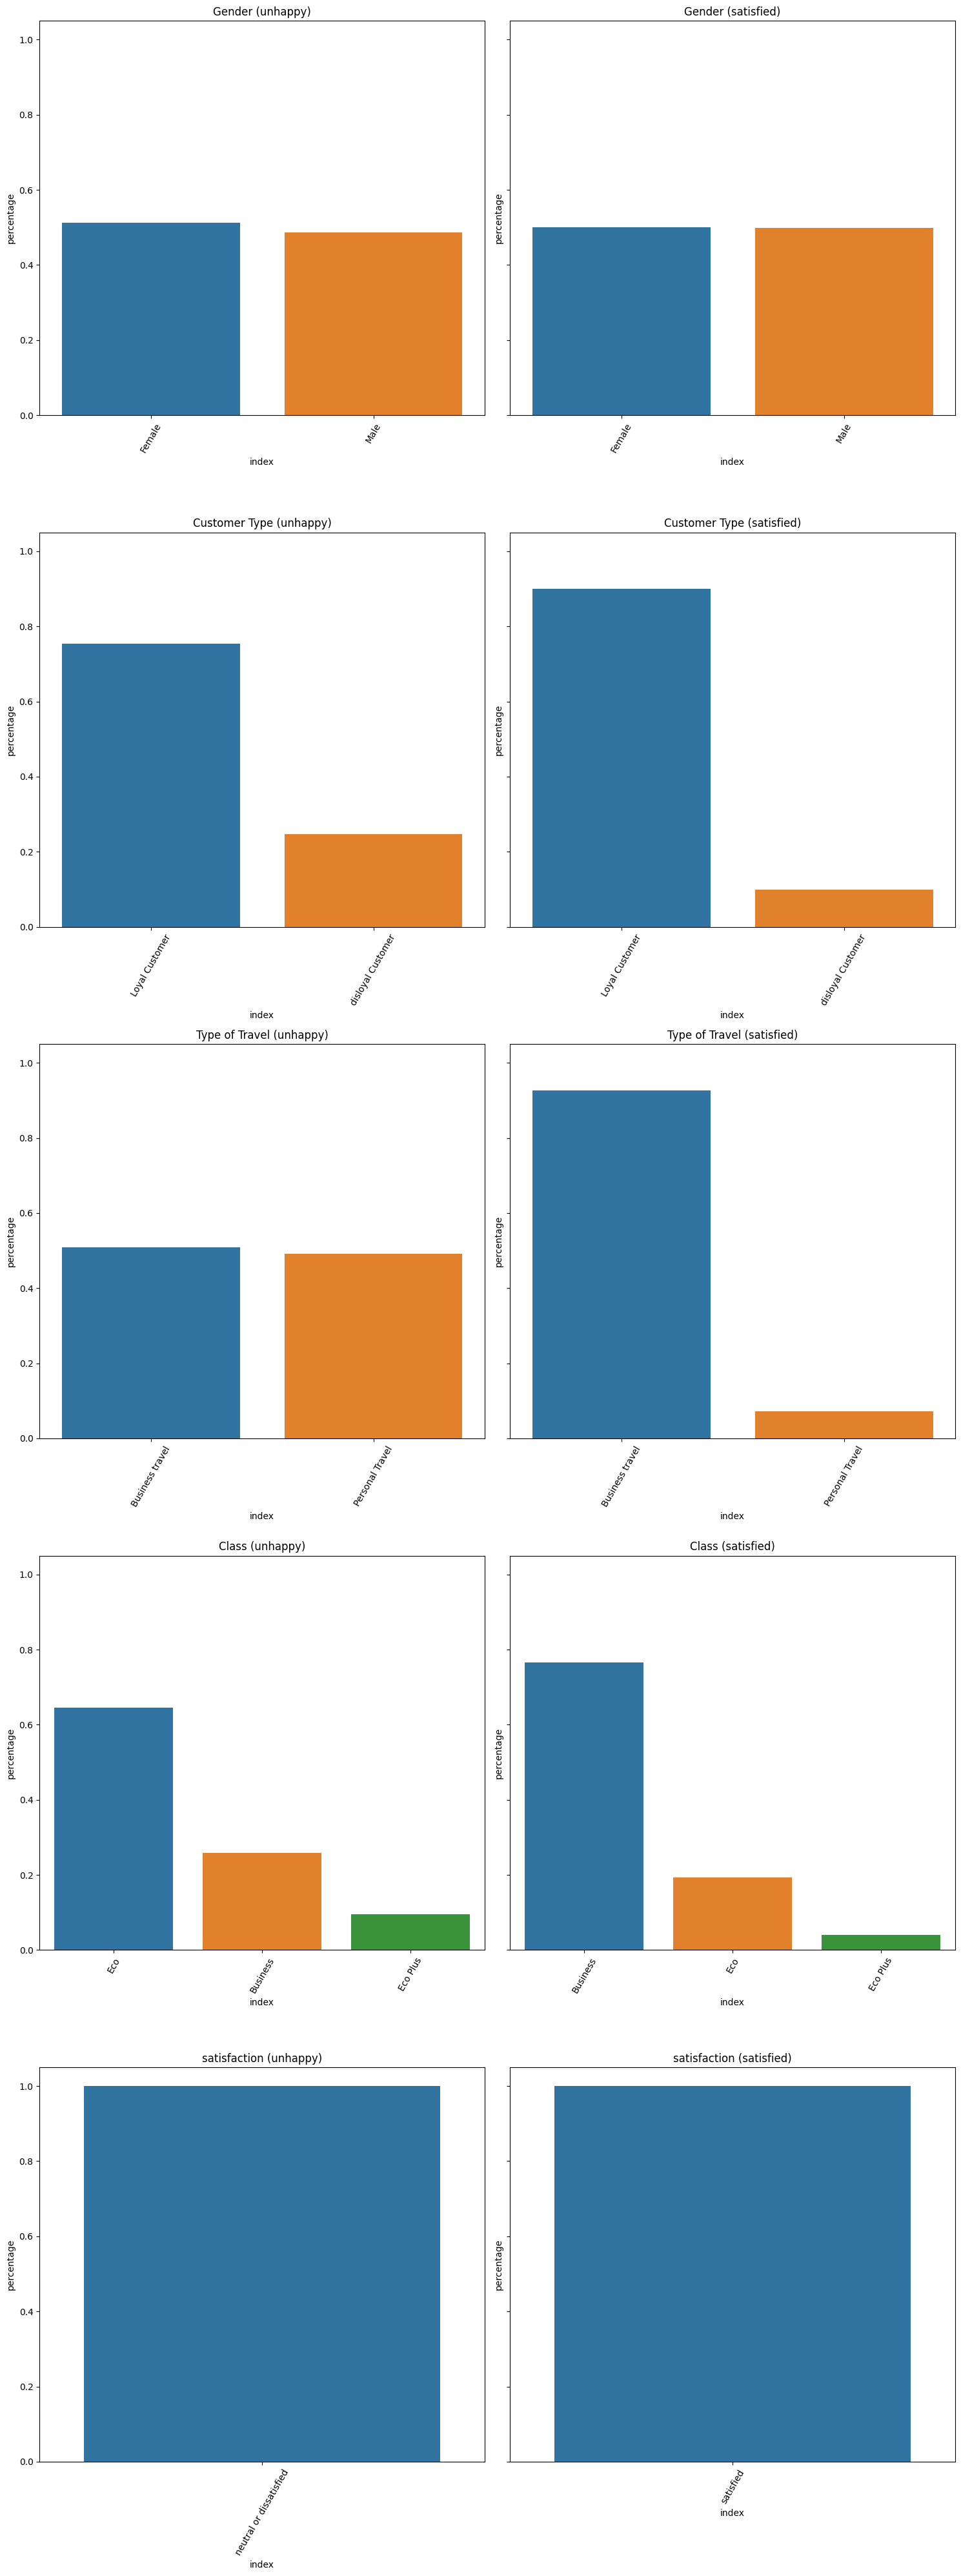

In [47]:
n = len(cat_features) #number of categorial features
fig, axes = plt.subplots(n, 2, figsize=(15, 40), sharey='all') #figure+n*2 coordinate axes with same y-scale
#creating cycle for categorial features
for i, feature in enumerate(cat_features):
    count_data_f = (unhappy[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(
        data=count_data_f, 
        x='index', 
        y='percentage', 
        ax=axes[i][0]
        )
    count_barplot.xaxis.set_tick_params(rotation=60)
    count_barplot.set(title=f'{feature} (unhappy)')
    count_data_s = (satisfied[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(
        data=count_data_s, 
        x='index', 
        y='percentage', 
        ax=axes[i][1]
        )
    count_barplot.xaxis.set_tick_params(rotation=60)
    count_barplot.set(title=f'{feature} (satisfied)')
plt.tight_layout() #alignment of features

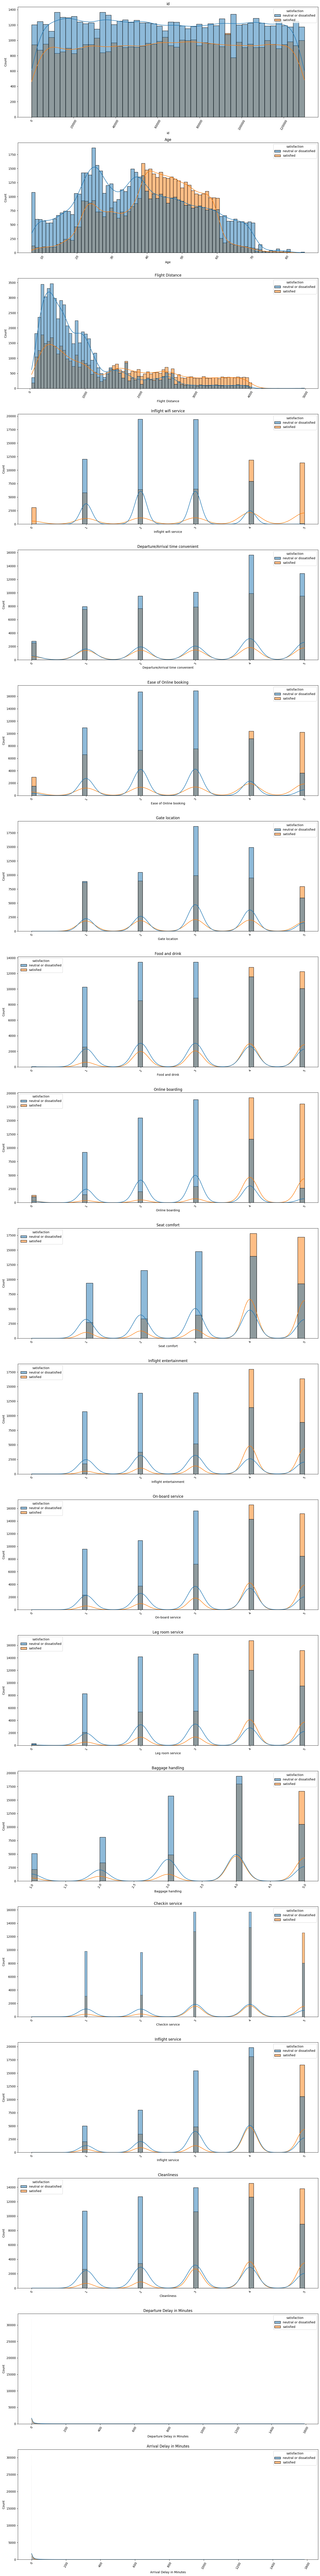

In [38]:
n = len(num_features) #number of numerical features
fig, axes = plt.subplots(n, 1, figsize=(15, 120)) #figure+n*2 coordinate axes with same y-scale
#creating cycle for categorial features
for i, feature in enumerate(num_features):
    #building percented barplots for on the left for clients who did not open deposit (failure)
    count_histplot = sns.histplot(
        data=air,
        x=feature, 
        hue='satisfaction',
        kde=True,
        ax=axes[i]
        )
    count_histplot.xaxis.set_tick_params(rotation=60)
    count_histplot.set(title=f'{feature}')

plt.tight_layout() #alignment of features

Перекодируем часть бинарных признаков, чтобы использовать их при обучении:

In [48]:
air['satisfaction'] = air['satisfaction'].map({'neutral or dissatisfied':0 , 'satisfied':1})
air['Customer Type'] = air['Customer Type'].map({'Loyal Customer':1, 'disloyal Customer':0})
air['Type of Travel'] = air['Type of Travel'].map({'Personal Travel':0, 'Business travel':1})
air['Gender'] = air['Gender'].map({'Male': 0, 'Female': 1})

In [50]:
air = pd.get_dummies(air)
air.shape[1]

26

Задание 6.5

Мы практически добрались до обучения модели. Разбейте данные на обучающую и тестовую выборки в соотношении 80/20, параметр random_state = 26. Сколько наблюдений попало в тестовую выборку?

In [51]:
X = air.drop(columns='satisfaction')
y = air['satisfaction']

In [56]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=26)
X_test.shape[0]

20781

Задание 6.6

Теперь нам необходимо реализовать масштабирование данных. Для этого обучите на обучающей выборке метод StandardScaler() и с помощью него преобразуйте и обучающую, и тестовую выборки. Не забудьте, что целевую переменную обрабатывать не нужно.

Примечание. Отметим, что если бы дальше мы работали только с деревьями, масштабирование бы не требовалось. Однако мы реализуем его, чтобы можно было обучать и другие модели и сравнивать полученные результаты.

В качестве ответа введите самое первое значение из матрицы преобразованных признаков тестовой выборки. Округлите значение до двух знаков после точки-разделителя.

In [63]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled_arr = scaler.transform(X_train)
X_test_scaled_arr = scaler.transform(X_test)

X_train = pd.DataFrame(
    X_train_scaled_arr,
    index=X_train.index,
    columns=X_train.columns,
    )

X_test = pd.DataFrame(
    X_test_scaled_arr,
    index=X_test.index,
    columns=X_test.columns,
    )



Задание 6.7

Перейдём к обучению моделей. В качестве первой модели возьмём самую простую — логистическую регрессию. Мы делаем это для того, чтобы потом сравнивать с ней полученные результаты: так вы сможете выяснить, насколько ансамбли смогут улучшить точность прогноза.

Обучите логистическую регрессию с параметрами по умолчанию на наших данных. В качестве ответа введите значение метрики f1_score. Ответ округлите до трёх знаков после точки-разделителя.

In [68]:
log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)
y_train_predict_log = log_reg.predict(X_train)
y_test_predict_log = log_reg.predict(X_test)

print('F1-score on train (log_reg):')
print(round(metrics.f1_score(y_train, y_train_predict_log), 3))
print('F1-score on test (log_reg):')
print(round(metrics.f1_score(y_test, y_test_predict_log), 3))

F1-score on train (log_reg):
0.854
F1-score on test (log_reg):
0.855


Задание 6.8

Теперь перейдём к бустингу. Начнём с обучения первой модели — AdaBoost. В качестве базовой модели для неё возьмите решающее дерево с параметром random_state = 26.

Обучите AdaBoost, зафиксировав random_state со значением 26 и задав темп обучения 0.01. В качестве ответа введите значение метрики f1_score. Ответ округлите до трёх знаков после точки-разделителя.

In [71]:
ada_boost = AdaBoostRegressor(
    random_state=26,
    learning_rate=0.01
    )

ada_boost.fit(X_train, y_train)
y_train_predict_ab = ada_boost.predict(X_train)
y_test_predict_ab = ada_boost.predict(X_test)

print('F1-score on train (ada_boost):')
print(round(metrics.f1_score(y_train, y_train_predict_ab), 3))
print('F1-score on test (ada_boost):')
print(round(metrics.f1_score(y_test, y_test_predict_ab), 3))


KeyboardInterrupt: 

Задание 6.9

Перейдем к следующему алгоритму — градиентному бустингу.

Будем настраивать количество деревьев и темп обучения, делая перебор по следующей сетке:

params = {"n_estimators":2**np.arange(8), "learning_rate":0.1**np.arange(3)}

Используйте для поиска оптимальных параметров GridSearchCV, а для ускорения работы алгоритма задайте параметр кросс-валидации, равный 3.

Какое наибольшее значение метрики f1_score получилось? Ответ округлите до трёх знаков после точки-разделителя.

Примечание. Необходимо указать лучший результат в методе GridSearchCV на тренировочных данных.